# ALGORITMOS BASADOS EN SERIES TEMPORALES

## 2) Modelo de Regresión Lineal con Variables Temporales (RLVT)
En este enfoque, se usa regresión lineal múltiple para estimar la demanda futura en función de variables de ventas pasadas:

### Fórmula General:
$Dt=β0 +β1 ⋅Vt +β2 ⋅Vt−1 +β3⋅Vt−12 +ϵ $

#### Donde:
* Dt = Demanda estimada del mes actual.
* 𝑉𝑡 = Ventas del mes en curso.
* 𝑉𝑡−1 = Ventas del mes anterior.
* 𝑉𝑡−12 = Ventas del mismo mes del año anterior.
* β0,β1,β2,β3 = Pesos asignados a cada variable, definidos con base en la importancia de cada factor.
* ϵ = Factor ofertas


### Estee modelo calcula la demanda como un promedio ponderado de:

* **Mes en curso (t)** → Refleja la demanda actual.
* **Mes anterior (t-1)** → Captura tendencias recientes.
* **Mismo mes del año anterior (t-12)** → Captura estacionalidad.



### Ventajas:
* ✅ Permite agregar más factores (promociones, precios, días festivos, eventos externos).
* ✅ Se puede optimizar con técnicas de Machine Learning para encontrar los mejores coeficientes.
* ✅ No requiere supuestos estrictos sobre estacionalidad.

### Desventajas:
* ❌ Supone relaciones lineales entre ventas pasadas y futuras (puede ser inexacto en mercados volátiles).


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pyodbc
from dotenv import dotenv_values

# Mostrar el DataFrame resultante
import ace_tools_open as tools

# Evitar Mensajes Molestos
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

In [16]:
# ELEGIR el PROVEEDOR

proveedor = 98
label = '98_FRATELLI_BRANCA'

# Cargar Datos
data = pd.read_csv(f'data/{label}.csv')
data.head()

# Adecuar Tipos de Datos
data['Sucursal']= data['Sucursal'].astype(int)
data['Codigo_Articulo']= data['Codigo_Articulo'].astype(int)
data['Fecha'] = pd.to_datetime(data['Fecha'])  # Convertir a formato datetime si aún no lo está
data.sort_values(by='Fecha', ascending=True)  # Ordenar por fecha de menor a mayor

# Crear una nueva columna con el mes y el año para análisis temporal
data['Año-Mes'] = data['Fecha'].dt.strftime('%Y-%m')

# Crear una nueva columna con el formato Año-Semana (AAAA-WW) a partir de la columna Fecha
data['Año-Semana'] = data['Fecha'].dt.strftime('%Y-%W')

# Confirmar que la columna sigue siendo un campo datetime
#print(data.dtypes)

#data = data.sort_values(by='Fecha', ascending=True)  # Ordenar en orden ascendente (del más antiguo al más reciente)
#data = data.reset_index()

# Recortar Cantidad de Datos ULTIMO AÑO COMPLETO
df = data[data['Fecha']>='2021-01-01']

In [15]:
df_grupo = df.groupby(['Codigo_Articulo', 'Sucursal','Año-Mes'])['Unidades'] \
                    .sum().reset_index().rename(columns={'Unidades': 'ventas_last'})

tools.display_dataframe_to_user(name="SET de Datos del Proveedor", dataframe=df_grupo)

SET de Datos del Proveedor


In [17]:
# import ace_tools_open as tools
tools.display_dataframe_to_user(name="SET de Datos del Proveedor", dataframe=data)

SET de Datos del Proveedor


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160821 entries, 0 to 160820
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Fecha            160821 non-null  datetime64[ns]
 1   Codigo_Articulo  160821 non-null  int32         
 2   Sucursal         160821 non-null  int32         
 3   Unidades         160821 non-null  float64       
 4   Año-Mes          160821 non-null  object        
 5   Año-Semana       160821 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(2), object(2)
memory usage: 6.1+ MB


## Analizar Graficos por Sucursal

In [ ]:
plt.figure(figsize=(18, 5))

# Graficar la serie original
data.plot.line(label="Serie Original", color="blue")

# Aplicar suavizamiento exponencial simple
fit1 = SimpleExpSmoothing(df_series).fit(smoothing_level=alpha_sm, optimized=False)

# Generar la predicción para los próximos 12 períodos
fcast1 = fit1.forecast(12).rename(f'alpha = {alpha_sm}')

# Corregir el índice de fechas para que siga a `df_series`
fcast1.index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=12, freq='D')

# Graficar valores ajustados
fit1.fittedvalues.plot(color='orange', label=f"Valores Ajustados (α={alpha_sm})")

# Graficar la predicción corregida
fcast1.plot(marker='o', color='red', legend=True, label=f"Pronóstico (α={alpha_sm})")

plt.title(f"Suavizamiento Exponencial Simple (α={alpha_sm})")
plt.legend()
plt.show()

In [ ]:
# Asegurar que la columna 'Fecha' es de tipo datetime
data['Fecha'] = pd.to_datetime(data['Fecha'])

# Agrupar las ventas por Fecha y Sucursal
ventas_por_local = data.groupby(['Año-Mes', 'Sucursal'])['Unidades'].sum().unstack()

# Crear la gráfica
plt.figure(figsize=(12, 6))
ventas_por_local.plot(marker='o', linestyle='-')

# Configuración de la gráfica
plt.title("Evolución de Ventas por Local a lo Largo del Tiempo")
plt.xlabel("Fecha")
plt.ylabel("Unidades Vendidas")
plt.legend(title="Sucursal", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Mostrar la gráfica
plt.show()

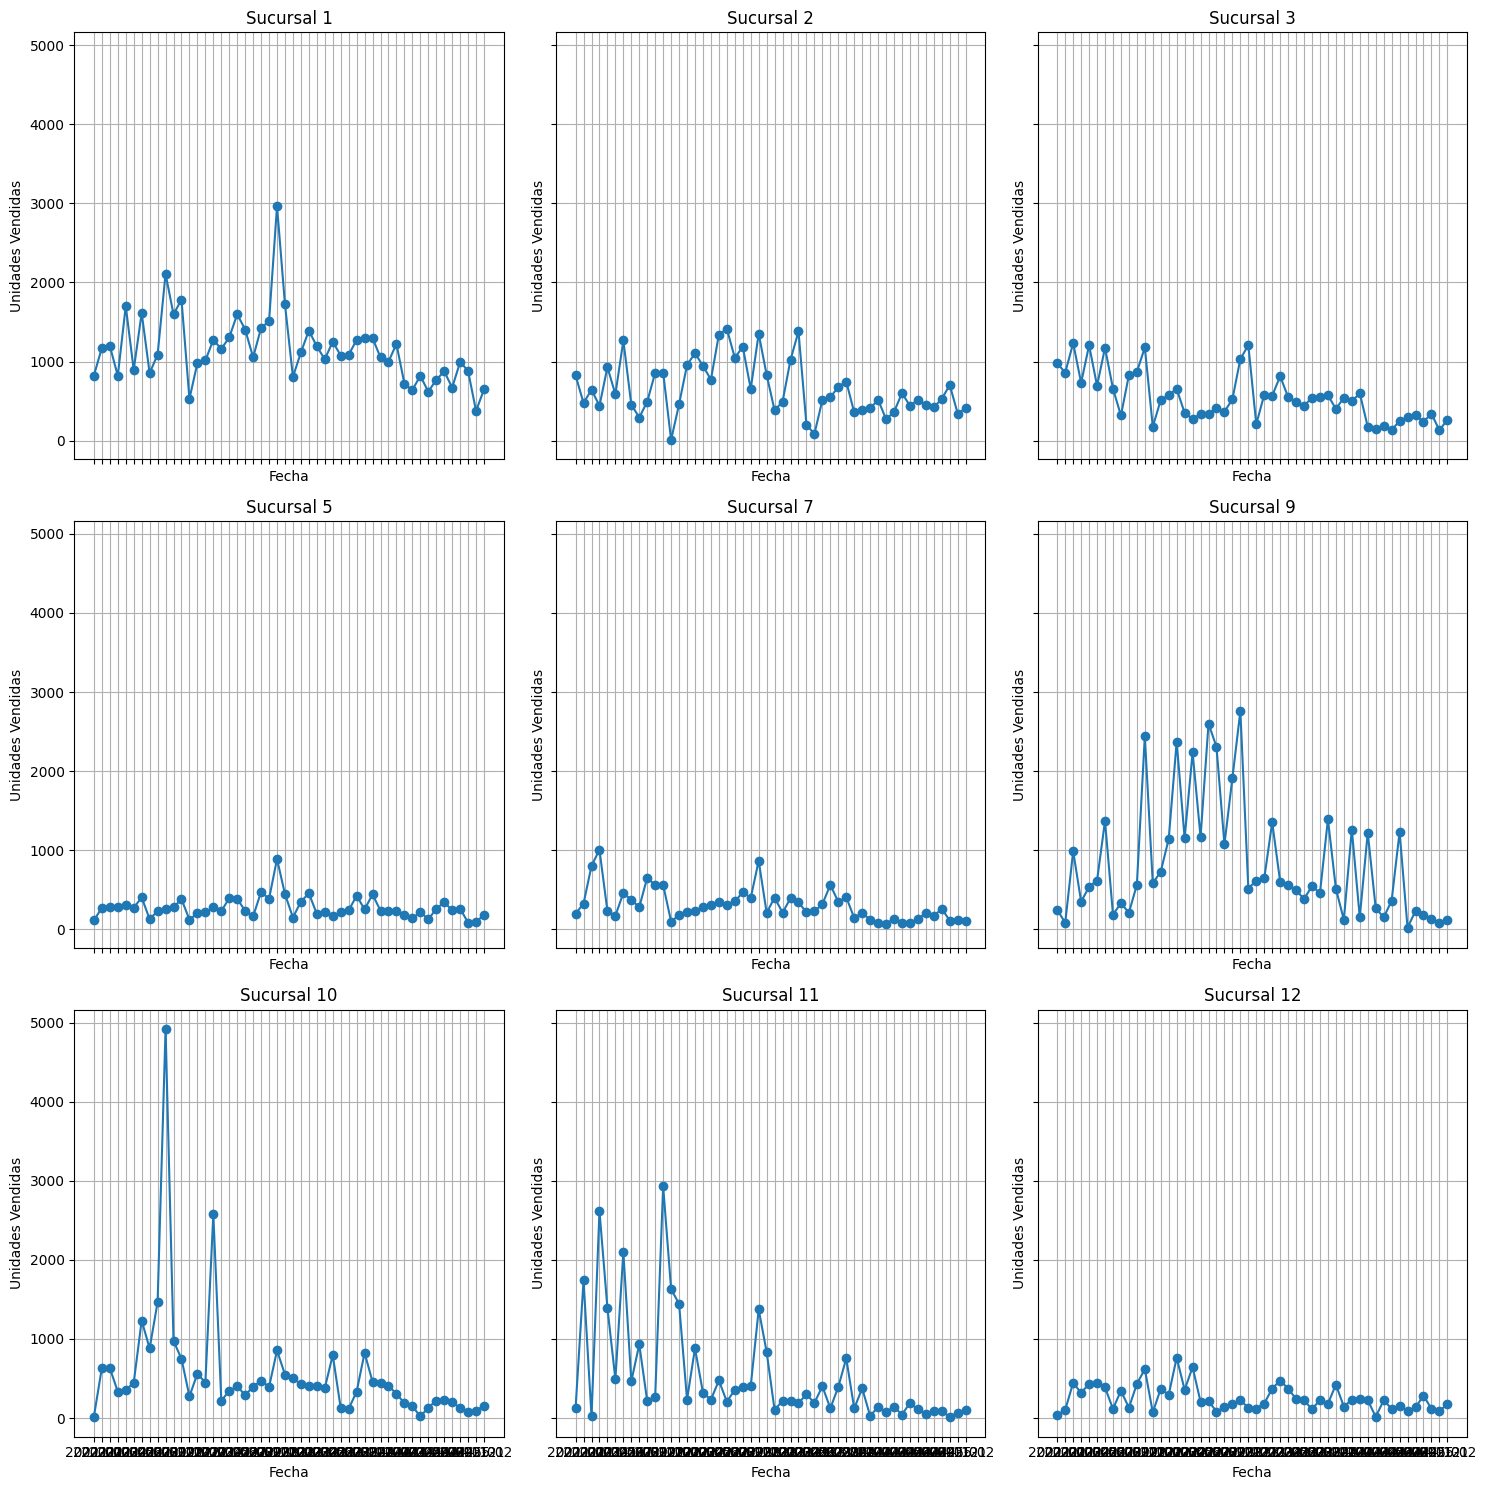

In [30]:
import matplotlib.pyplot as plt

# Definir el rango de sucursales a visualizar
sucursal_min = 1   # Cambiar según necesidad
sucursal_max = 12  # Cambiar según necesidad

# Asegurar que la columna 'Fecha' es de tipo datetime
data['Fecha'] = pd.to_datetime(data['Fecha'])

# Filtrar las sucursales en el rango definido
sucursales_filtradas = data['Sucursal'].unique()
sucursales_filtradas = [s for s in sucursales_filtradas if sucursal_min <= s <= sucursal_max]

# Número de subgráficos a generar
num_sucursales = len(sucursales_filtradas)
filas = (num_sucursales // 3) + (num_sucursales % 3 > 0)  # Organizar en filas de 3 columnas

# Crear figura y subgráficos
fig, axes = plt.subplots(filas, 3, figsize=(15, 5 * filas), sharex=True, sharey=True)
axes = axes.flatten()  # Aplanar matriz de subgráficos

# Graficar cada sucursal por separado
for i, sucursal in enumerate(sucursales_filtradas):
    # Filtrar datos de la sucursal
    df_sucursal = data[data['Sucursal'] == sucursal]

    # Agrupar por 'Año-Mes' para ventas agregadas en el tiempo
    # ventas_por_mes = df_sucursal.groupby('Año-Mes')['Unidades'].sum()
    ventas_por_mes = df_sucursal.groupby('Año-Mes')['Unidades'].sum()

    # Graficar en el subplot correspondiente
    axes[i].plot(ventas_por_mes.index, ventas_por_mes.values, marker='o', linestyle='-')
    axes[i].set_title(f"Sucursal {sucursal}")
    axes[i].set_xlabel("Fecha")
    axes[i].set_ylabel("Unidades Vendidas")
    axes[i].grid(True)

# Ajustar diseño
plt.tight_layout()
plt.show()


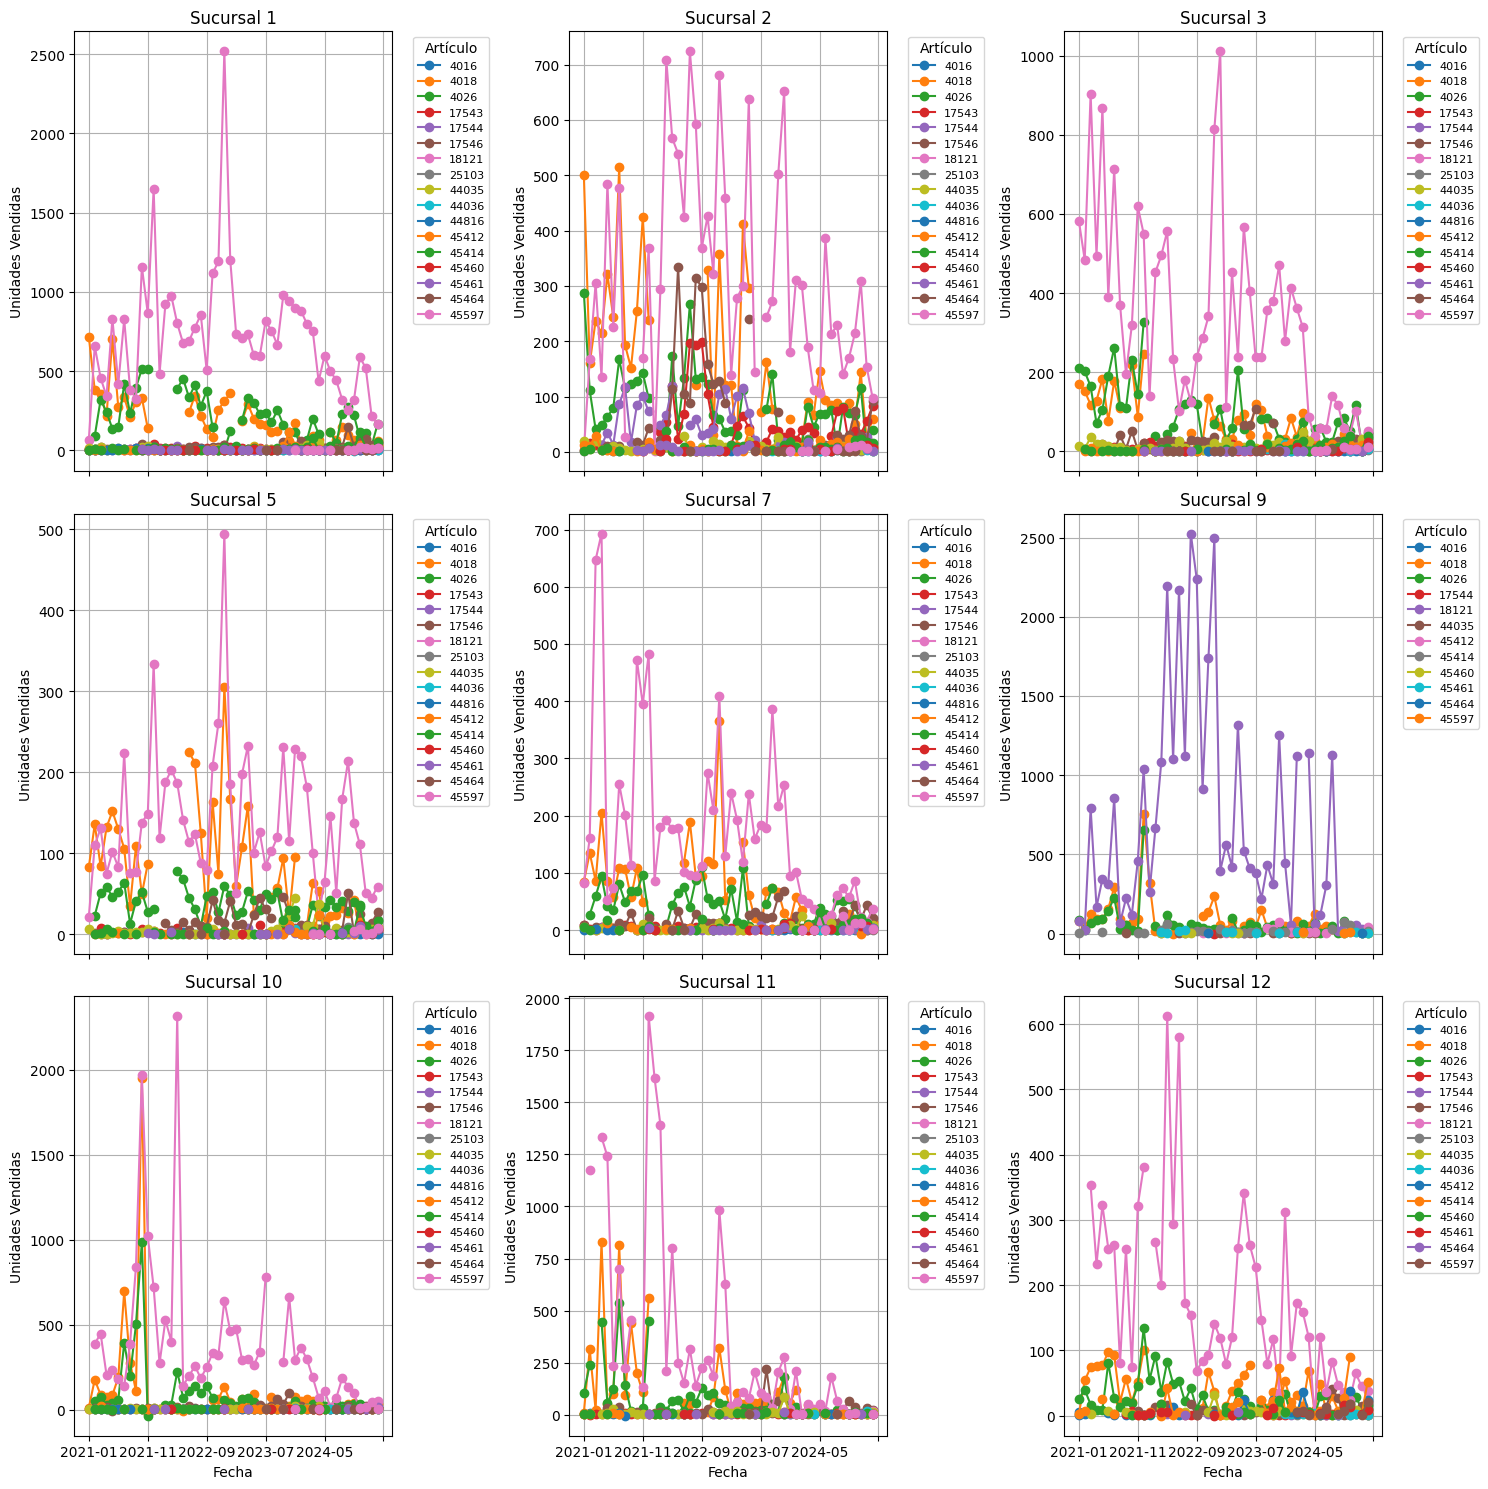

In [32]:
import matplotlib.pyplot as plt

# Definir el rango de sucursales a visualizar
sucursal_min = 1   # Cambiar según necesidad
sucursal_max = 12  # Cambiar según necesidad

# Asegurar que la columna 'Fecha' es de tipo datetime
data['Fecha'] = pd.to_datetime(data['Fecha'])

# Filtrar sucursales dentro del rango definido
sucursales_filtradas = data['Sucursal'].unique()
sucursales_filtradas = [s for s in sucursales_filtradas if sucursal_min <= s <= sucursal_max]

# Número de subgráficos a generar
num_sucursales = len(sucursales_filtradas)
filas = (num_sucursales // 3) + (num_sucursales % 3 > 0)  # Organizar en filas de 3 columnas

# Crear figura y subgráficos
fig, axes = plt.subplots(filas, 3, figsize=(15, 5 * filas), sharex=True, sharey=False)
axes = axes.flatten()  # Aplanar matriz de subgráficos

# Graficar cada sucursal por separado
for i, sucursal in enumerate(sucursales_filtradas):
    # Filtrar datos de la sucursal específica
    df_sucursal = data[data['Sucursal'] == sucursal]

    # Agrupar por 'Año-Mes' y 'Código_Articulo' para obtener ventas agregadas en el tiempo
    ventas_por_articulo = df_sucursal.groupby(['Año-Mes', 'Codigo_Articulo'])['Unidades'].sum().unstack()

    # Graficar cada artículo dentro de la sucursal
    ventas_por_articulo.plot(ax=axes[i], marker='o', linestyle='-')

    # Configuración del gráfico
    axes[i].set_title(f"Sucursal {sucursal}")
    axes[i].set_xlabel("Fecha")
    axes[i].set_ylabel("Unidades Vendidas")
    axes[i].grid(True)
    axes[i].legend(title="Artículo", fontsize=8, bbox_to_anchor=(1.05, 1), loc='upper left')

# Ajustar diseño
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

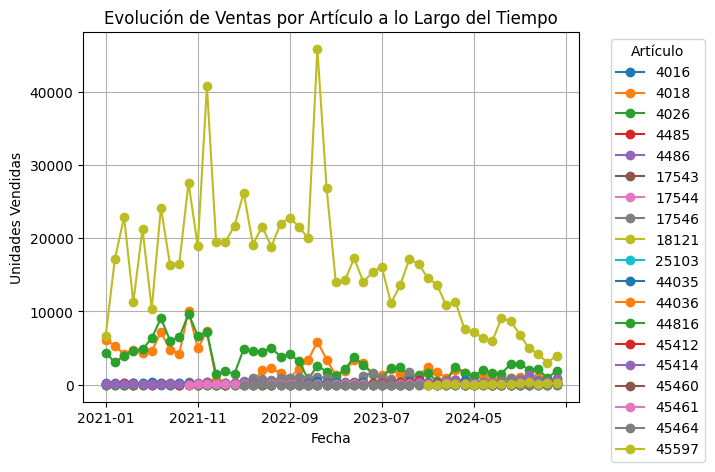

In [33]:
# Asegurar que la columna 'Fecha' es de tipo datetime
data['Fecha'] = pd.to_datetime(data['Fecha'])

# Agrupar las ventas por Fecha y Sucursal
ventas_por_articulo = data.groupby(['Año-Mes', 'Codigo_Articulo'])['Unidades'].sum().unstack()

# Crear la gráfica
plt.figure(figsize=(12, 6))
ventas_por_articulo.plot(marker='o', linestyle='-')

# Configuración de la gráfica
plt.title("Evolución de Ventas por Artículo a lo Largo del Tiempo")
plt.xlabel("Fecha")
plt.ylabel("Unidades Vendidas")
plt.legend(title="Artículo", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Mostrar la gráfica
plt.show()

## a) Versión INICIAL

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Asegurar que la columna 'Año-Mes' está en formato datetime
df['Año-Mes'] = pd.to_datetime(df['Año-Mes'].astype(str))

# Agrupar las ventas mensuales por artículo y sucursal
df_ventas_mensuales = df.groupby(['Año-Mes', 'Codigo_Articulo', 'Sucursal'])['Unidades'].sum().reset_index()

# Crear variables de lag (ventas del mes anterior y mismo mes del año anterior)
df_ventas_mensuales['lag_1'] = df_ventas_mensuales.groupby(['Codigo_Articulo', 'Sucursal'])['Unidades'].shift(1)
df_ventas_mensuales['lag_12'] = df_ventas_mensuales.groupby(['Codigo_Articulo', 'Sucursal'])['Unidades'].shift(12)

# Eliminar filas con valores nulos generados por los lags
df_ventas_mensuales.dropna(inplace=True)

# Definir variables predictoras (X) y variable objetivo (y)
X = df_ventas_mensuales[['lag_1', 'lag_12']]
y = df_ventas_mensuales['Unidades']

# Dividir en conjunto de entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo de regresión lineal
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = modelo.predict(X_test)

# Evaluar el modelo
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Mostrar resultados
print(f"Error Absoluto Medio (MAE): {mae:.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f}")


Error Absoluto Medio (MAE): 47.60
Raíz del Error Cuadrático Medio (RMSE): 137.42


In [20]:
# Crear un DataFrame con las predicciones
df_forecast = df_ventas_mensuales[['Año-Mes', 'Codigo_Articulo', 'Sucursal']].copy()
df_forecast['Forecast_Unidades'] = modelo.predict(X)  # Predicción con el modelo

# Merge con el DataFrame original de ventas mensuales
df_resultado = df_ventas_mensuales.merge(df_forecast, on=['Año-Mes', 'Codigo_Articulo', 'Sucursal'], how='left')

# Ordenar por fecha y mostrar las primeras filas
df_resultado = df_resultado.sort_values(by=['Codigo_Articulo', 'Sucursal', 'Año-Mes'])

# Mostrar resultado
import ace_tools_open  as tools
tools.display_dataframe_to_user(name="Forecast de Ventas", dataframe=df_resultado)


Forecast de Ventas


### b) MEJORAS

### ✅ Agregar más variables:

* **Precio del producto:** Puede afectar la demanda.
* **Promociones/descuentos:** Puede influir en las ventas.
* **Tendencias globales:** Se puede agregar una tendencia para mejorar la predicción.


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Asegurar que 'Año-Mes' está en formato datetime
df['Año-Mes'] = pd.to_datetime(df['Año-Mes'].astype(str))

# Agrupar las ventas mensuales por artículo y sucursal, sumando unidades vendidas y promediando el precio
df_ventas_mensuales = df.groupby(['Año-Mes', 'Codigo_Articulo', 'Sucursal']).agg(
    Unidades=('Unidades', 'sum'),
    Precio=('Precio', 'mean')  # Precio promedio del mes
).reset_index()

# Crear variables de lag (ventas del mes anterior y del mismo mes del año anterior)
df_ventas_mensuales['lag_1'] = df_ventas_mensuales.groupby(['Codigo_Articulo', 'Sucursal'])['Unidades'].shift(1)
df_ventas_mensuales['lag_12'] = df_ventas_mensuales.groupby(['Codigo_Articulo', 'Sucursal'])['Unidades'].shift(12)

# Crear variable de lag del precio del mes anterior
df_ventas_mensuales['lag_1_precio'] = df_ventas_mensuales.groupby(['Codigo_Articulo', 'Sucursal'])['Precio'].shift(1)

# Crear variable de descuento: Si el precio bajó más de un 5% respecto al mes anterior
df_ventas_mensuales['Descuento'] = (df_ventas_mensuales['lag_1_precio'] > df_ventas_mensuales['Precio'] * 1.05).astype(int)

# Agregar una tendencia global (número de mes desde el inicio de la serie)
df_ventas_mensuales['Tendencia'] = (df_ventas_mensuales['Año-Mes'] - df_ventas_mensuales['Año-Mes'].min()).dt.days // 30

# Eliminar filas con valores nulos generados por los lags
df_ventas_mensuales.dropna(inplace=True)

# Definir variables predictoras (X) y variable objetivo (y)
X = df_ventas_mensuales[['lag_1', 'lag_12', 'lag_1_precio', 'Descuento', 'Tendencia']]
y = df_ventas_mensuales['Unidades']

# Dividir en conjunto de entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo de regresión lineal
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = modelo.predict(X_test)

# Evaluar el modelo
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Mostrar resultados
print(f"Error Absoluto Medio (MAE): {mae:.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f}")

# Mostrar los coeficientes del modelo
coeficientes = pd.DataFrame(modelo.coef_, X.columns, columns=['Coeficiente'])
print(coeficientes)


Error Absoluto Medio (MAE): 210.17
Raíz del Error Cuadrático Medio (RMSE): 485.01
              Coeficiente
lag_1            0.507094
lag_12           0.234337
lag_1_precio    -0.018463
Descuento       60.109185
Tendencia       -2.679969


In [6]:
# Crear un DataFrame con las predicciones
df_forecast = df_ventas_mensuales[['Año-Mes', 'Codigo_Articulo', 'Sucursal']].copy()
df_forecast['Forecast_Unidades'] = modelo.predict(X)  # Predicción con el modelo

# Merge con el DataFrame original de ventas mensuales
df_resultado = df_ventas_mensuales.merge(df_forecast, on=['Año-Mes', 'Codigo_Articulo', 'Sucursal'], how='left')

# Ordenar por fecha y mostrar las primeras filas
df_resultado = df_resultado.sort_values(by=['Codigo_Articulo', 'Sucursal', 'Año-Mes'])

# Mostrar resultado
import ace_tools_open  as tools
tools.display_dataframe_to_user(name="Forecast de Ventas", dataframe=df_resultado)

Forecast de Ventas


### 3) Otra Prueba

## 2) MODELO ML REGRESION LINEAL

In [7]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def create_training_data(df, period_length=30, min_date=None, max_date=None):
    """
    Genera un conjunto de entrenamiento mediante ventanas móviles.
    
    Para cada combinación de 'Codigo_Articulo' y 'Sucursal', se calculan:
      - 'ventas_last': Ventas acumuladas en los últimos 'period_length' días (ventana actual).
      - 'ventas_previous': Ventas acumuladas en el período anterior inmediato (previo a la ventana actual).
      - 'ventas_same_year': Ventas acumuladas en el mismo período del año anterior.
      - 'target': Ventas acumuladas en el período inmediatamente posterior a la ventana actual.
    
    Se requiere que existan datos suficientes para cubrir cada uno de los períodos.
    
    Parámetros:
      - df: DataFrame con los datos históricos.
      - period_length: Número de días que conforman cada ventana (por defecto 30).
      - min_date: Fecha mínima para considerar la fecha de corte (forecast_date) en el entrenamiento.
      - max_date: Fecha máxima para la fecha de corte; se recomienda que sea menor o igual a (Fecha máxima del df - period_length).
    
    Retorna:
      - training_df: DataFrame con las features y el target para cada ejemplo de entrenamiento.
    """
    # Asegurarse de que la columna 'Fecha' sea de tipo datetime
    df['Fecha'] = pd.to_datetime(df['Fecha'])
    
    # Definir un rango viable para la fecha de corte (forecast_date)
    overall_min_date = df['Fecha'].min() + pd.Timedelta(days=2*period_length) + pd.DateOffset(years=1)
    overall_max_date = df['Fecha'].max() - pd.Timedelta(days=period_length)
    
    if min_date is None:
        min_date = overall_min_date
    if max_date is None:
        max_date = overall_max_date
    
    training_rows = []
    
    # Se agrupa la información por artículo y sucursal
    groups = df.groupby(['Codigo_Articulo', 'Sucursal'])
    
    for (codigo, sucursal), group in groups:
        group = group.sort_values('Fecha')
        # Se obtienen las fechas únicas disponibles en el grupo
        fechas_unicas = group['Fecha'].unique()
        # Se filtran las fechas que se encuentran en el rango viable para forecast_date
        viable_dates = [d for d in fechas_unicas if (d >= min_date) and (d <= max_date)]
        
        for forecast_date in viable_dates:
            # Definir ventanas:
            # Ventana actual (últimos period_length días hasta forecast_date)
            last_start = forecast_date - pd.Timedelta(days=period_length - 1)
            last_end = forecast_date
            # Ventana anterior inmediata
            previous_start = forecast_date - pd.Timedelta(days=2*period_length)
            previous_end = forecast_date - pd.Timedelta(days=period_length)
            # Mismo período del año anterior
            same_year_start = forecast_date - pd.DateOffset(years=1) - pd.Timedelta(days=period_length - 1)
            same_year_end = forecast_date - pd.DateOffset(years=1)
            # Período objetivo (target) a pronosticar: los period_length días siguientes a forecast_date
            target_start = forecast_date + pd.Timedelta(days=1)
            target_end = forecast_date + pd.Timedelta(days=period_length)
            
            # Filtrar el grupo según cada ventana
            mask_last = (group['Fecha'] >= last_start) & (group['Fecha'] <= last_end)
            mask_previous = (group['Fecha'] >= previous_start) & (group['Fecha'] <= previous_end)
            mask_same_year = (group['Fecha'] >= same_year_start) & (group['Fecha'] <= same_year_end)
            mask_target = (group['Fecha'] >= target_start) & (group['Fecha'] <= target_end)
            
            ventas_last = group.loc[mask_last, 'Unidades'].sum()
            ventas_previous = group.loc[mask_previous, 'Unidades'].sum()
            ventas_same_year = group.loc[mask_same_year, 'Unidades'].sum()
            target_sales = group.loc[mask_target, 'Unidades'].sum()
            
            # Se pueden agregar condiciones para omitir ejemplos sin información (por ejemplo, si target es nulo)
            # En este ejemplo se incluyen todos los casos, asumiendo que ventas nulas representan 0.
            training_rows.append({
                'Codigo_Articulo': codigo,
                'Sucursal': sucursal,
                'forecast_date': forecast_date,
                'ventas_last': ventas_last,
                'ventas_previous': ventas_previous,
                'ventas_same_year': ventas_same_year,
                'target': target_sales
            })
    
    training_df = pd.DataFrame(training_rows)
    return training_df

def forecast_linear_regression(df, forecast_date=None, period_length=30, training_min_date=None, training_max_date=None):
    """
    Realiza la predicción de la demanda utilizando un modelo de regresión lineal.
    
    Procedimiento:
      1. Se crea un conjunto de entrenamiento a partir de los datos históricos mediante la función 'create_training_data'.
      2. Se entrena un modelo global de regresión lineal utilizando como variables independientes:
           - ventas_last, ventas_previous, ventas_same_year
         y como variable dependiente el target (ventas acumuladas en el período posterior).
      3. Para cada combinación de 'Codigo_Articulo' y 'Sucursal', se calculan las features correspondientes al período
         de pronóstico definido por 'forecast_date' y se predice la demanda.
    
    Parámetros:
      - df: DataFrame con la información histórica.
      - forecast_date: Fecha para la cual se desea pronosticar la demanda. Si no se indica, se toma (Fecha máxima - period_length).
      - period_length: Número de días que definen cada ventana (por defecto 30).
      - training_min_date: Fecha mínima para incluir ejemplos en el entrenamiento.
      - training_max_date: Fecha máxima para incluir ejemplos en el entrenamiento.
    
    Retorna:
      - forecast_df: DataFrame con la predicción para cada artículo y sucursal.
      - model: Modelo de regresión lineal entrenado.
      - training_df: Conjunto de entrenamiento utilizado.
    """
    # Asegurarse de que la columna 'Fecha' sea de tipo datetime
    df['Fecha'] = pd.to_datetime(df['Fecha'])
    
    # Definir la fecha de pronóstico si no se especifica
    if forecast_date is None:
        forecast_date = df['Fecha'].max() - pd.Timedelta(days=period_length)
    else:
        forecast_date = pd.to_datetime(forecast_date)
    
    # Crear el conjunto de entrenamiento
    training_df = create_training_data(df, period_length=period_length, min_date=training_min_date, max_date=training_max_date)
    
    if training_df.empty:
        raise ValueError("No se pudo generar el conjunto de entrenamiento. Verifique el rango de fechas y la información disponible.")
    
    # Definir las variables independientes (features) y la variable dependiente (target)
    features = ['ventas_last', 'ventas_previous', 'ventas_same_year']
    X_train = training_df[features]
    y_train = training_df['target']
    
    # Entrenar el modelo de regresión lineal
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Para la fecha de pronóstico, se calculan las features para cada combinación de artículo y sucursal
    forecast_rows = []
    groups = df.groupby(['Codigo_Articulo', 'Sucursal'])
    
    for (codigo, sucursal), group in groups:
        group = group.sort_values('Fecha')
        # Definir las ventanas para la fecha de pronóstico
        last_start = forecast_date - pd.Timedelta(days=period_length - 1)
        last_end = forecast_date
        previous_start = forecast_date - pd.Timedelta(days=2*period_length)
        previous_end = forecast_date - pd.Timedelta(days=period_length)
        same_year_start = forecast_date - pd.DateOffset(years=1) - pd.Timedelta(days=period_length - 1)
        same_year_end = forecast_date - pd.DateOffset(years=1)
        
        mask_last = (group['Fecha'] >= last_start) & (group['Fecha'] <= last_end)
        mask_previous = (group['Fecha'] >= previous_start) & (group['Fecha'] <= previous_end)
        mask_same_year = (group['Fecha'] >= same_year_start) & (group['Fecha'] <= same_year_end)
        
        ventas_last = group.loc[mask_last, 'Unidades'].sum()
        ventas_previous = group.loc[mask_previous, 'Unidades'].sum()
        ventas_same_year = group.loc[mask_same_year, 'Unidades'].sum()
        
        # Vector de features para la predicción
        X_pred = np.array([[ventas_last, ventas_previous, ventas_same_year]])
        pred = model.predict(X_pred)[0]
        
        forecast_rows.append({
            'Codigo_Articulo': codigo,
            'Sucursal': sucursal,
            'forecast': int(round(pred)),
            'ventas_last': ventas_last,
            'ventas_previous': ventas_previous,
            'ventas_same_year': ventas_same_year
        })
    
    forecast_df = pd.DataFrame(forecast_rows)
    return forecast_df, model, training_df


In [8]:
fechas = pd.date_range(start='2023-01-01', end='2025-02-10', freq='D')
np.random.seed(42)

#df = pd.DataFrame(data)

In [9]:
# Se define la fecha de pronóstico: por ejemplo, la última fecha disponible menos period_length
forecast_date = df['Fecha'].max() - pd.Timedelta(days=30)

# Se ejecuta el algoritmo de regresión lineal para obtener la predicción
forecast_lr, model, training_data = forecast_linear_regression(
    df, 
    forecast_date=forecast_date, 
    period_length=30
    # Se pueden especificar training_min_date y training_max_date si se desea limitar el conjunto de entrenamiento
)

print("Demanda estimada utilizando el algoritmo de regresión lineal:")
print(forecast_lr.head())

e:\PY\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
e:\PY\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
e:\PY\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
e:\PY\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
e:\PY\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
e:\PY\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not ha

Demanda estimada utilizando el algoritmo de regresión lineal:
   Codigo_Articulo  Sucursal  forecast  ventas_last  ventas_previous  \
0              166         1        78          0.0              0.0   
1              166         2        78          0.0              0.0   
2              166         3        78          0.0              0.0   
3              166         4        78          0.0              0.0   
4              166         5        78          0.0              0.0   

   ventas_same_year  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0  


In [10]:
# Evaluación del modelo en el conjunto de entrenamiento
X_train = training_data[['ventas_last', 'ventas_previous', 'ventas_same_year']]
y_train = training_data['target']
y_pred_train = model.predict(X_train)
mae = mean_absolute_error(y_train, y_pred_train)
mse = mean_squared_error(y_train, y_pred_train)
print(f"MAE en entrenamiento: {mae:.2f}")
print(f"MSE en entrenamiento: {mse:.2f}")

MAE en entrenamiento: 214.23
MSE en entrenamiento: 224828.45


In [12]:
from sklearn.metrics import  mean_absolute_percentage_error
mape = mean_absolute_percentage_error(y_train, y_pred_train)
print(f"MAPE en entrenamiento: {mape:.2f}")


MAPE en entrenamiento: 9804081636873698.00


In [20]:
# Mostrar el DataFrame resultante

# Merge con el DataFrame original de ventas mensuales
# df_resultado_lr = forecast_lr.merge(y_pred_train, on=['Año-Mes', 'Codigo_Articulo', 'Sucursal'], how='left')


import ace_tools_open as tools
tools.display_dataframe_to_user(name="Data - Artículos con Demanda", dataframe=training_data)

Data - Artículos con Demanda
